In [15]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec

from rdkit import Chem, DataStructs
from rdkit.Chem import Descriptors,Crippen

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import matplotlib.cm as cm
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans

import sys
!conda install --yes --prefix {sys.prefix} seaborn
import seaborn as sns

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 22.11.0
  latest version: 22.11.1

Please update conda by running

    $ conda update -n base -c defaults conda

Or to minimize the number of packages updated during conda update use

     conda install conda=22.11.1



# All requested packages already installed.



In [16]:
df = pd.read_csv(r"path/filename")
print(df)

                                           SMILES   mol MW     SASA     FOSA  \
0                       CNC(=O)[C@@H](CCO)NC(=O)C  174.199  425.510  280.113   
1                    CC(=O)N[C@H](C(=O)NC)c1ccsc1  212.266  459.001  199.537   
2                   CC(=O)N[C@@H](C(=O)NC)c1ccsc1  212.266  462.678  200.276   
3               CC(=O)NC(C1)(C(=O)NC)Cc(c12)cccc2  232.282  501.551  260.464   
4                         CC(=O)NC1(C(=O)NC)CCCC1  184.238  439.701  366.098   
...                                           ...      ...      ...      ...   
3418        CC(=O)N[C@@](C)(C(=O)NC)Cc1cc[nH+]cc1  235.285  485.138  266.405   
3419             CC(=O)N[C@](C)(C(=O)NC)Cc1ccncc1  235.285  482.502  260.659   
3420         CC(=O)N[C@](C)(C(=O)NC)Cc1cc[nH+]cc1  235.285  477.860  263.128   
3421     CC(=O)N[C@H](C(=O)OC)Cc1c[nH]c(c12)cccc2  260.292  512.248  216.188   
3422  CC(=O)N[C@H](C(=O)OC)Cc1c[nH]c(c12)cc(F)cc2  278.282  538.654  224.697   

         FISA     PISA    WPSA  donorHB

In [17]:
descriptors = df.loc[:, ['mol MW', 'SASA', 'FOSA', 'FISA','PISA', 'WPSA','donorHB','accptHB','glob','QPlogPo/w','PSA']].values

In [18]:
descriptors_std = StandardScaler().fit_transform(descriptors)

In [19]:
pca = PCA(n_components = 3)
descriptors_2d = pca.fit_transform(descriptors_std)

In [20]:
descriptors_pca= pd.DataFrame(descriptors_2d)
descriptors_pca.index = df.index
descriptors_pca.columns = ['PC{}'.format(i+1) for i in descriptors_pca.columns]
descriptors_pca.head(10)

,PC1,PC2,PC3
0,-0.771809,3.300831,-0.327477
1,0.015450,-0.620441,-1.303677
2,0.085703,-0.796966,-1.202368
3,0.274518,-1.507041,0.324911
4,-2.394510,-0.082153,0.418254
5,-2.563723,0.476949,-1.334367
6,-2.489201,0.415029,-1.194920
7,-2.488938,0.414998,-1.194249
8,-2.563722,0.476949,-1.334366
9,-1.094856,-1.279416,-1.724084


In [21]:
print(pca.explained_variance_ratio_) 
print(sum(pca.explained_variance_ratio_))

[0.33770789 0.30170541 0.11910954]
0.7585228390378541


<Figure size 800x600 with 0 Axes>

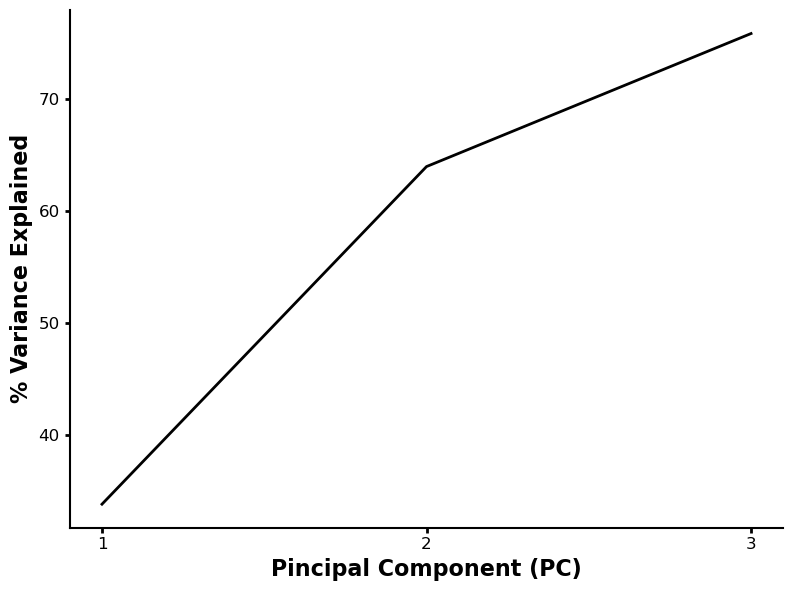

In [22]:
plt.rcParams['axes.linewidth'] = 1.5
plt.figure(figsize=(8,6))
fig, ax = plt.subplots(figsize=(8,6))

var=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=3)*100)
plt.plot([i+1 for i in range(len(var))],var,'k-',linewidth=2)
plt.xticks([i+1 for i in range(len(var))])
plt.ylabel('% Variance Explained',fontsize=16,fontweight='bold')
plt.xlabel('Pincipal Component (PC)',fontsize=16,fontweight='bold')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.tick_params ('both',width=2,labelsize=12)

In [23]:
scale1 = 1.0/(max(descriptors_pca['PC1']) - min(descriptors_pca['PC1']))
scale2 = 1.0/(max(descriptors_pca['PC2']) - min(descriptors_pca['PC2']))
scale3 = 1.0/(max(descriptors_pca['PC3']) - min(descriptors_pca['PC3']))
descriptors_pca['PC1_normalized']=[i*scale1 for i in descriptors_pca['PC1']]
descriptors_pca['PC2_normalized']=[i*scale2 for i in descriptors_pca['PC2']]
descriptors_pca['PC3_normalized']=[i*scale3 for i in descriptors_pca['PC3']]

In [24]:
descriptors_pca.head(10)

,PC1,PC2,PC3,PC1_normalized,PC2_normalized,PC3_normalized
0,-0.771809,3.300831,-0.327477,-0.055431,0.281665,-0.041886
1,0.015450,-0.620441,-1.303677,0.001110,-0.052943,-0.166746
2,0.085703,-0.796966,-1.202368,0.006155,-0.068006,-0.153788
3,0.274518,-1.507041,0.324911,0.019716,-0.128598,0.041558
4,-2.394510,-0.082153,0.418254,-0.171973,-0.007010,0.053496
5,-2.563723,0.476949,-1.334367,-0.184126,0.040699,-0.170671
6,-2.489201,0.415029,-1.194920,-0.178774,0.035415,-0.152835
7,-2.488938,0.414998,-1.194249,-0.178755,0.035412,-0.152749
8,-2.563722,0.476949,-1.334366,-0.184126,0.040699,-0.170671
9,-1.094856,-1.279416,-1.724084,-0.078632,-0.109174,-0.220518


/usr/local/Caskroom/miniconda/base/envs/my-rdkit-env/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  after removing the cwd from sys.path.


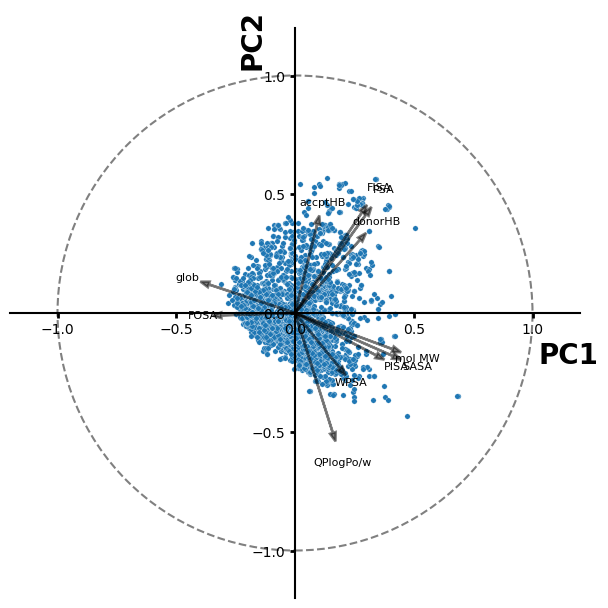

In [25]:
plt.rcParams['axes.linewidth'] = 1.5
plt.figure(figsize=(6,6))

ax=sns.scatterplot(x='PC1_normalized',y='PC2_normalized',data=descriptors_pca,s=15,palette=sns.color_palette("Set2", 3),linewidth=0.2,alpha=1)

plt.xlabel ('PC1',fontsize=20,fontweight='bold')
ax.xaxis.set_label_coords(0.98, 0.45)
plt.ylabel ('PC2',fontsize=20,fontweight='bold')
ax.yaxis.set_label_coords(0.45, 0.98)

ax.spines['left'].set_position(('data', 0))
ax.spines['bottom'].set_position(('data', 0))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


lab=['mol MW', 'SASA', 'FOSA', 'FISA','PISA', 'WPSA','donorHB','accptHB','glob','QPlogPo/w','PSA'] 

l=np.transpose(pca.components_[0:2, :]) 

n = l.shape[0]
for i in range(n):
    plt.arrow(0, 0, l[i,0], l[i,1],color= 'k',alpha=0.5,linewidth=1.8,head_width=0.025)
    plt.text(l[i,0]*1.25, l[i,1]*1.25, lab[i], color = 'k',va = 'center', ha = 'center',fontsize = 8)

circle = plt.Circle((0,0), 1, color='gray', fill=False,clip_on=True,linewidth=1.5,linestyle='--')

plt.tick_params ('both',width=2,labelsize=10)

ax.add_artist(circle)
plt.xlim(-1.2,1.2)
plt.ylim(-1.2,1.2)
plt.tight_layout()
plt.show()

In [26]:
df=df.join(descriptors_pca)

In [27]:
df.head

<bound method NDFrame.head of                                            SMILES   mol MW     SASA     FOSA  \
0                       CNC(=O)[C@@H](CCO)NC(=O)C  174.199  425.510  280.113   
1                    CC(=O)N[C@H](C(=O)NC)c1ccsc1  212.266  459.001  199.537   
2                   CC(=O)N[C@@H](C(=O)NC)c1ccsc1  212.266  462.678  200.276   
3               CC(=O)NC(C1)(C(=O)NC)Cc(c12)cccc2  232.282  501.551  260.464   
4                         CC(=O)NC1(C(=O)NC)CCCC1  184.238  439.701  366.098   
...                                           ...      ...      ...      ...   
3418        CC(=O)N[C@@](C)(C(=O)NC)Cc1cc[nH+]cc1  235.285  485.138  266.405   
3419             CC(=O)N[C@](C)(C(=O)NC)Cc1ccncc1  235.285  482.502  260.659   
3420         CC(=O)N[C@](C)(C(=O)NC)Cc1cc[nH+]cc1  235.285  477.860  263.128   
3421     CC(=O)N[C@H](C(=O)OC)Cc1c[nH]c(c12)cccc2  260.292  512.248  216.188   
3422  CC(=O)N[C@H](C(=O)OC)Cc1c[nH]c(c12)cc(F)cc2  278.282  538.654  224.697   

         

In [28]:
df.to_csv('path/filename')